# Transformation + correlation analysis

## update text based on papers
This notebook examines the correlation structure in the gene expression data generated in [1_create_compendia.ipynb](../processing/1_create_compendia.ipynb).

When we performed clustering on the correlation matrices (using Pearson correlation) we found that pairs of genes had either very high correlation scores (>0.5) or very low correlation scores (<0.1). As a result gene pairs that were highly correlated clustered into a single large module. This clustering pattern is not ideal for a couple of reasons:
1. Given that our goal is to examine the composition of gene groups, having all genes within one module does not allow us to do this
2. These highly correlated group of genes are likely masking other relevant specific signals/relationships in the data

Here we will apply transformations of the raw gene expression data before applying clustering to see if this helps to correct for this high level of correlation

In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import plotnine as pn
import seaborn as sns
import matplotlib.pyplot as plt
import umap
import random
import numpy as np
from sklearn import preprocessing
from core_acc_modules import paths

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Set user parameters

For now we will vary the correlation threshold (`corr_threshold`) but keep the other parameters consistent

We will run this notebook for each threshold parameter

In [2]:
# Params -- REMOVE???
corr_threshold = 0.5

# Output files
pao1_membership_filename = f"pao1_membership_{corr_threshold}.tsv"
pa14_membership_filename = f"pa14_membership_{corr_threshold}.tsv"

In [3]:
# Load expression data
pao1_compendium_filename = paths.PAO1_COMPENDIUM
pa14_compendium_filename = paths.PA14_COMPENDIUM

In [4]:
pao1_compendium = pd.read_csv(pao1_compendium_filename, sep="\t", header=0, index_col=0)
pa14_compendium = pd.read_csv(pa14_compendium_filename, sep="\t", header=0, index_col=0)

In [5]:
print(pao1_compendium.shape)
pao1_compendium.head()

(847, 5563)


PA0001      PA0002      PA0003      PA0004      PA0005  \
ERX541579  150.908951   63.968306   56.863002   86.013480   32.240954   
ERX541580  108.323515   56.079007   57.001674   73.421480   18.426169   
ERX541591  556.704228  182.309588   81.730476  157.348561   85.185006   
ERX541592  428.470250  178.510235   74.953217  152.142022   92.393069   
ERX676205  555.932721  530.701952  295.028891  336.887163  160.855884   

               PA0006     PA0007      PA0008      PA0009     PA0010  ...  \
ERX541579   48.322611  21.099413   21.219456   31.521424  12.168960  ...   
ERX541580   46.572630  16.606703   18.595344   30.253393  15.936006  ...   
ERX541591  116.643999  36.964524   31.973493   63.109930  16.140763  ...   
ERX541592   95.317522  33.668009   31.262234   81.131515  20.126563  ...   
ERX676205  196.799841  24.062303  127.448405  251.543954  29.933785  ...   

              PA1905      PA0195      PA4812   PA0195.1   PA0457.1  \
ERX541579   0.000000   16.606783   38.218939   8.611779  28.396413   
ERX541580   0.000000   13.904292   37.246074  11.777708  45.733000   
ERX541591  14.312595   73.032021   80.369628  49.312460  69.099677   
ERX541592   6.691671  114.618032   62.583672  56.426453  58.473904   
ERX676205   9.935461   59.660341  268.159400  40.929204  30.272774   

             PA1552.1    PA1555.1      PA3701    PA4724.1   PA5471.1  
ERX541579  110.943698  137.583940  101.058282   65.210599   0.000000  
ERX541580   94.799523   53.486191   82.753701   23.340646  38.113576  
ERX541591   61.622295  103.911157  186.030844  478.965167   0.000000  
ERX541592   55.311934  101.620394  207.409539  345.057960   0.000000  
ERX676205  284.146647  357.806954  260.651493  110.621722   0.000000  

[5 rows x 5563 columns]

In [6]:
print(pa14_compendium.shape)
pa14_compendium.head()

(520, 5891)


PA14_55610  PA14_55600  PA14_55590  PA14_55580  PA14_55570  \
ERX1477379   11.030217    1.370300    0.683438   63.527772   34.586977   
ERX1477380   13.419626    3.039174    1.334504  105.003820   70.493150   
ERX1477381   13.155391    5.684725    7.208220  143.201487  107.849795   
ERX2174773    4.201447    4.194614    3.283683    3.273384   20.188057   
ERX2174774    5.016892    3.306859    3.446703    2.676762   17.199329   

            PA14_55560  PA14_55550  PA14_55540  PA14_55530  PA14_55520  ...  \
ERX1477379    4.709054    5.274344    8.137393    5.310585    0.766974  ...   
ERX1477380    8.849012    6.802855   18.784232   11.978251    2.088495  ...   
ERX1477381   12.753058    8.868100   27.482294   13.951196    1.251785  ...   
ERX2174773    3.804287    2.665245    2.650568   20.062716    3.755125  ...   
ERX2174774    3.748607    1.618736    4.083091   21.225030    2.373772  ...   

            PA14_19205  PA14_17675  PA14_67975  PA14_36345  PA14_43405  \
ERX1477379   10.688588   82.981151   63.650349   28.877599    7.956130   
ERX1477380   15.823345   91.090917   62.400165   24.819442    3.132517   
ERX1477381   28.406181   98.909427   71.429549   24.114657    6.515803   
ERX2174773   41.954387   35.821193  114.727681  104.737209    0.000000   
ERX2174774   44.138587   26.599121  105.848301  104.402335    0.000000   

            PA14_38825  PA14_24245  PA14_28895  PA14_55117  PA14_59845  
ERX1477379   56.829502  269.183334    6.074311   29.079407  100.748813  
ERX1477380   31.325168  181.774134   10.866863   16.090103  233.317754  
ERX1477381   18.616579  184.357151   13.112427   13.970424   93.182566  
ERX2174773  391.722223  160.215744   18.980486   20.985404  182.605858  
ERX2174774  444.485136  168.538985   24.906987   19.775702  206.865218  

[5 rows x 5891 columns]

## Correlation of raw gene expression data

Use this as a comparison to see how the correlations are changed after each correction method

In [7]:
# Correlation
pao1_corr_original = pao1_compendium.corr()
pa14_corr_original = pa14_compendium.corr()

Text(0.5, 1.05, 'Correlation of raw PAO1 genes')

<Figure size 1440x1440 with 0 Axes>

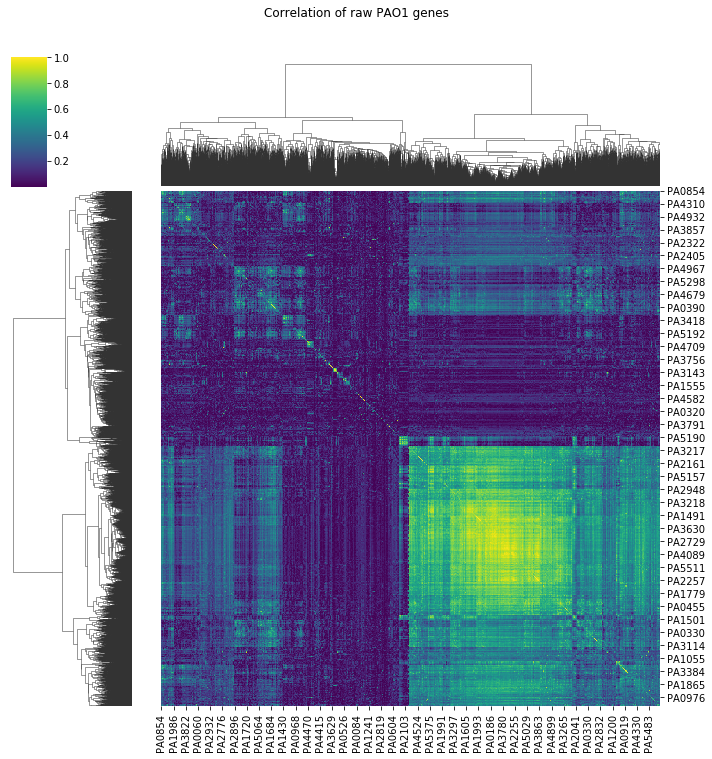

In [8]:
# Plot heatmap
plt.figure(figsize=(20, 20))
o1 = sns.clustermap(pao1_corr_original.abs(), cmap="viridis")
o1.fig.suptitle("Correlation of raw PAO1 genes", y=1.05)

Text(0.5, 1.05, 'Correlation of raw PA14 genes')

<Figure size 1440x1440 with 0 Axes>

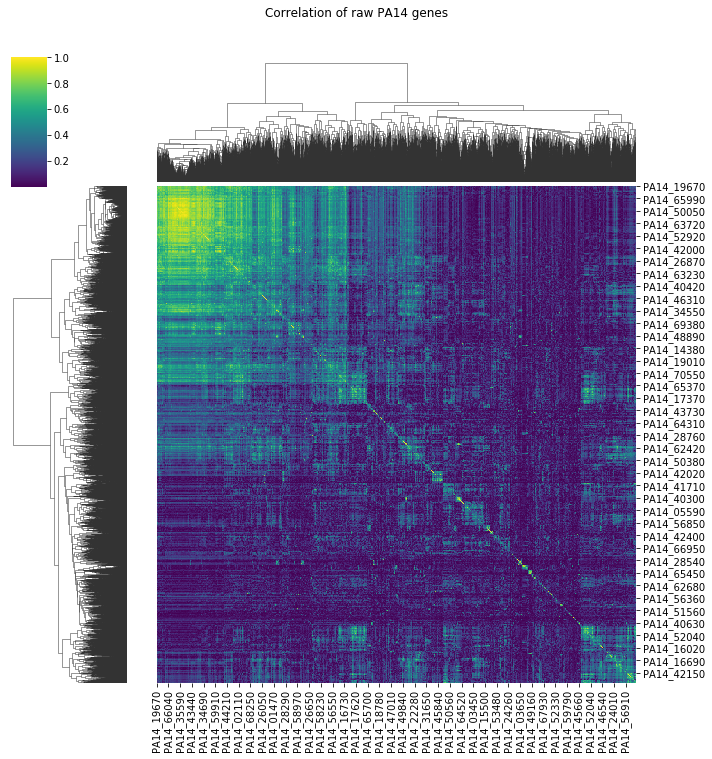

In [9]:
# Plot heatmap
plt.figure(figsize=(20, 20))
o2 = sns.clustermap(pa14_corr_original.abs(), cmap="viridis")
o2.fig.suptitle("Correlation of raw PA14 genes", y=1.05)

## Scaling + correlation

Try different processing of the raw gene expression data and then applying correlation:
* log transform + correlation
* Normalize + correlation

### Log transform + correlation

In [10]:
# log transform data
# Note: add 1 to avoid -inf and so 0 corresponds to those with 0 counts
pao1_compendium_log10 = np.log10(1 + pao1_compendium)
pa14_compendium_log10 = np.log10(1 + pa14_compendium)

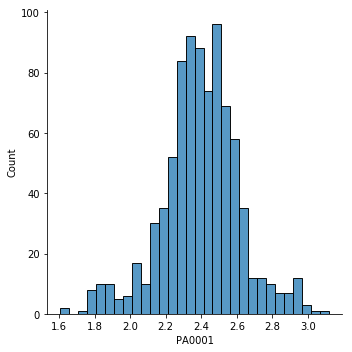

In [19]:
sns.displot(pao1_compendium_log10["PA0001"])

In [11]:
# Correlation
pao1_corr_log10 = pao1_compendium_log10.corr()
pa14_corr_log10 = pa14_compendium_log10.corr()

Text(0.5, 1.05, 'Correlation of log10 transformed PAO1 genes')

<Figure size 1440x1440 with 0 Axes>

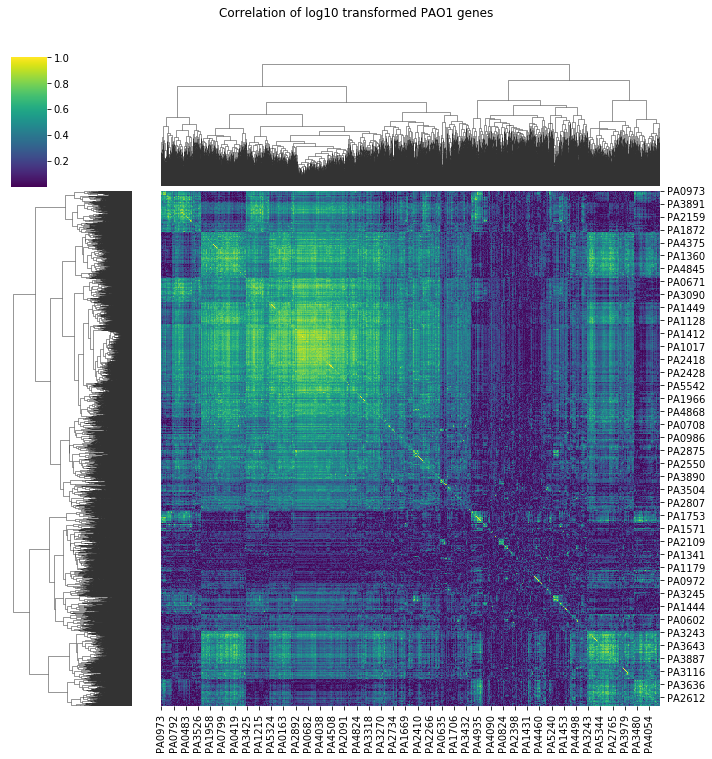

In [12]:
# Plot heatmap
plt.figure(figsize=(20, 20))
h1 = sns.clustermap(pao1_corr_log10.abs(), cmap="viridis")
h1.fig.suptitle("Correlation of log10 transformed PAO1 genes", y=1.05)

Text(0.5, 1.05, 'Correlation of log10 transformed PA14 genes')

<Figure size 1440x1440 with 0 Axes>

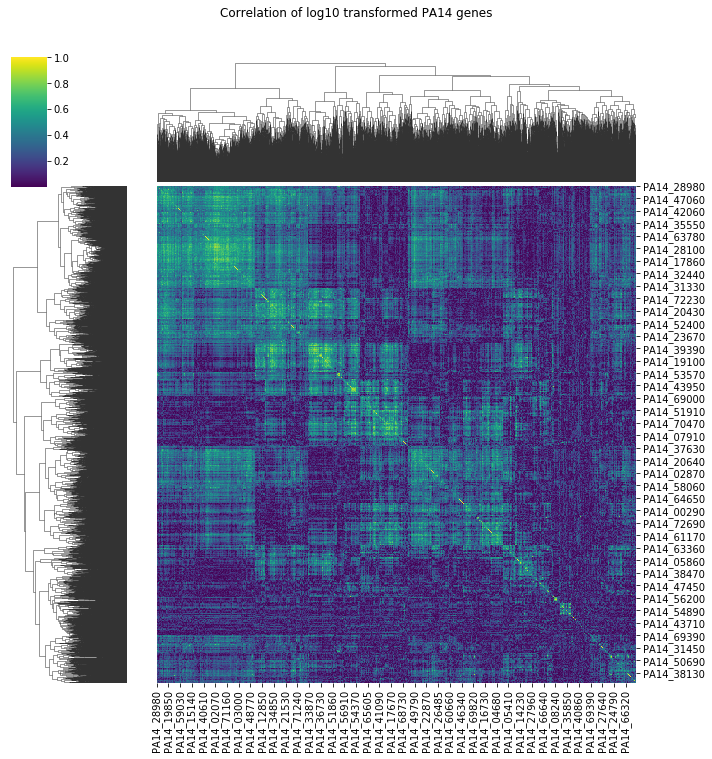

In [13]:
plt.figure(figsize=(20, 20))
h2 = sns.clustermap(pa14_corr_log10.abs(), cmap="viridis")
h2.fig.suptitle("Correlation of log10 transformed PA14 genes", y=1.05)

### 0-1 normalize + correlation

In [14]:
# 0-1 normalize per gene
scaler = preprocessing.MinMaxScaler()

pao1_scaled = scaler.fit_transform(pao1_compendium)
pao1_scaled_df = pd.DataFrame(
    pao1_scaled, columns=pao1_compendium.columns, index=pao1_compendium.index
)

scaler2 = preprocessing.MinMaxScaler()
pa14_scaled = scaler2.fit_transform(pa14_compendium)
pa14_scaled_df = pd.DataFrame(
    pa14_scaled, columns=pa14_compendium.columns, index=pa14_compendium.index
)

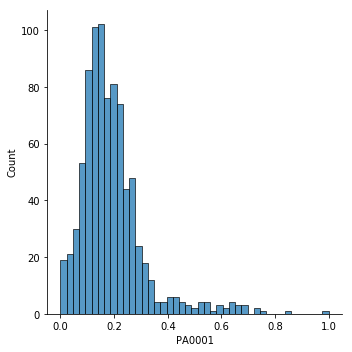

In [15]:
sns.displot(pao1_scaled_df["PA0001"])

In [16]:
# Correlation
pao1_corr_normalized = pao1_scaled_df.corr()
pa14_corr_normalized = pa14_scaled_df.corr()

Text(0.5, 1.05, 'Correlation of 0-1 normalized PAO1 genes')

<Figure size 1440x1440 with 0 Axes>

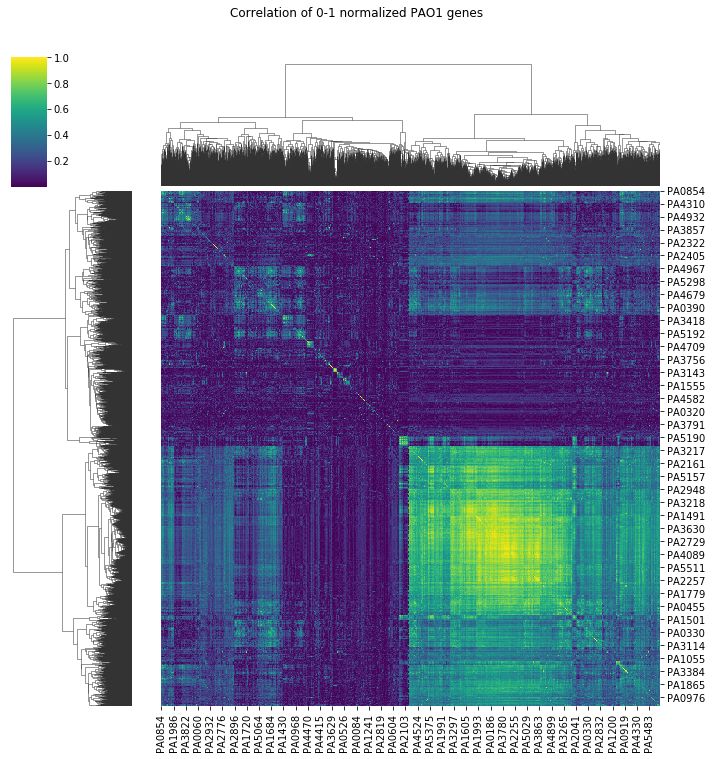

In [17]:
# Plot heatmap
plt.figure(figsize=(20, 20))
h3 = sns.clustermap(pao1_corr_normalized.abs(), cmap="viridis")
h3.fig.suptitle("Correlation of 0-1 normalized PAO1 genes", y=1.05)

Text(0.5, 1.05, 'Correlation of 0-1 normalized PA14 genes')

<Figure size 1440x1440 with 0 Axes>

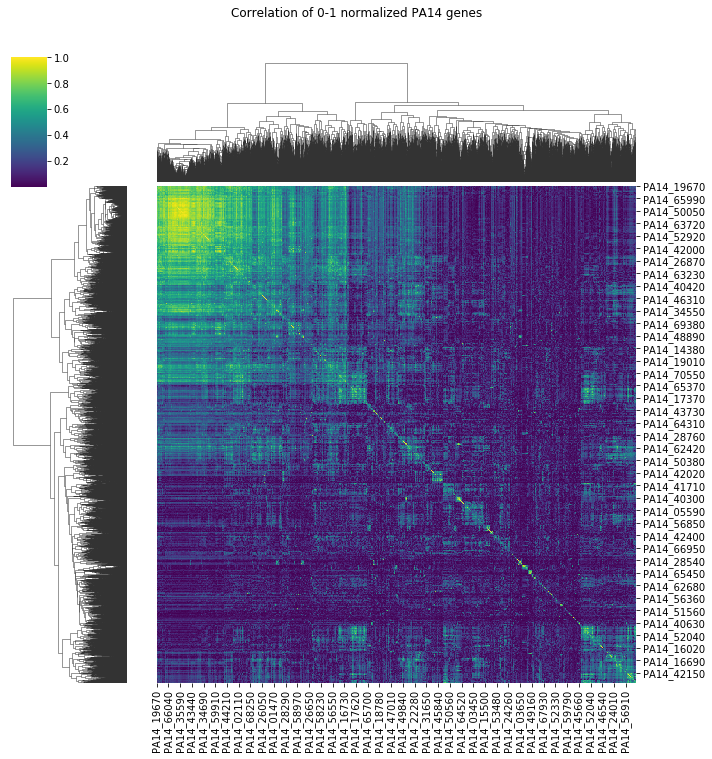

In [18]:
plt.figure(figsize=(20, 20))
h4 = sns.clustermap(pa14_corr_normalized.abs(), cmap="viridis")
h4.fig.suptitle("Correlation of 0-1 normalized PA14 genes", y=1.05)

**Takeaway:**
Here we are using the Pearson correlation metric, which is defined by the formula:

$$ \frac{\sigma_{XY}}{\sigma_X \sigma_Y}$$

In other words, the correlation is calculated based on the covariance between X,Y (i.e. how X jointly varies with Y) and the scaled by the standard deviation of X and Y (i.e. how variable X and Y are). So this Pearson correlation is testing for linear associations between X and Y.

* We find the same correlation patterns if we compare the raw data vs normalized data. This is because the normalization we perform is scaling the values linearly.
* By comparison, if we apply a non-linear scaling like log transform, the correlation values are changed. In fact, the correlation patterns using log data reveals more smaller modules compared to using raw data. After applying the log transform to our data, the data will be compressed (i.e. values in the right tail will be scaled down and these high values are what are creating the very dominant high correlation scores. Looking at the equation above the correlation score will be high if the covariance is high. And the covariance will be high if gene X and Y have long right tails and low means which they tend to as seen in the displots above).